In [23]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
import pickle
import os
import numpy as np

In [5]:
num = 85

In [6]:
with open(f'data_strengths_jsons/data_vs_mc_strengths_{num}.json', 'r') as f:
    md = json.load(f)
len(md)

85

In [7]:
with open(f'mc_strengths_jsons/ecf_tagger_strengths_{num}.json','r') as f:
    tg = json.load(f)
len(tg)

85

In [8]:
common_keys = md.keys() & tg.keys()
x_values = [md[k] for k in common_keys]
y_values = [tg[k] for k in common_keys]

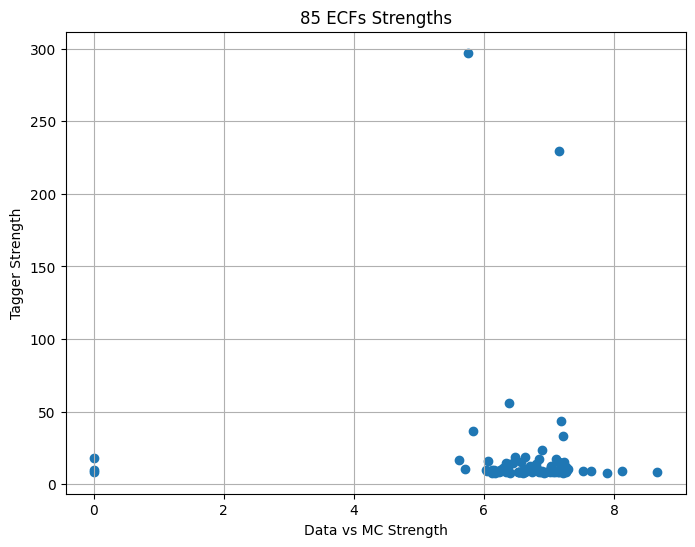

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.xlabel('Data vs MC Strength')
plt.ylabel('Tagger Strength')
plt.title(f'{num} ECFs Strengths')
plt.grid(True)
# plt.axvline(x=6.3)
plt.savefig(f'strength_plots/{num}.png')
plt.show()

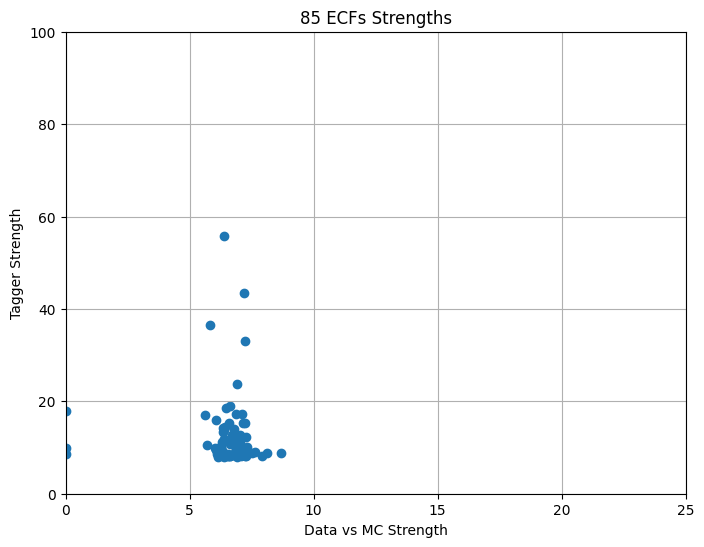

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.xlabel('Data vs MC Strength')
plt.ylabel('Tagger Strength')
plt.title(f'{num} ECFs Strengths')
plt.grid(True)
plt.ylim(0,100)
plt.xlim(0,25)
plt.show()

In [11]:
common_keys = md.keys() & tg.keys()
df = pd.DataFrame({
    'key': list(common_keys),
    'md': [md[k] for k in common_keys],
    'tg': [tg[k] for k in common_keys],
})

# Rank by high md values and low tg values (descending md, ascending tg)
df['rank'] = df['md'].rank(ascending=True) + df['tg'].rank(ascending=False)

# Sort by combined ranking
df_sorted = df.sort_values('rank').reset_index(drop=True)

print(df_sorted[['key', 'md', 'tg', 'rank']])

                                    key        md          tg   rank
0   ugm_1e525/3e505**1_6666666666666667  5.755055  297.181641    7.0
1                  ugm_1e510/1e410**1_0  5.836158   36.503506   12.0
2   grm_1e525/3e505**1_6666666666666667  0.000000   17.893791   12.0
3                grm_9e510/2e540**1_125  5.611075   16.991354   17.0
4                  ugm_8e530/5e540**1_2  6.066832   15.917071   24.0
..                                  ...       ...         ...    ...
80  ugm_6e520/3e330**1_3333333333333333  6.924215    7.936294  142.0
81  ugm_7e515/6e415**1_1666666666666667  7.228612    8.338553  143.0
82  grm_4e525/3e325**1_3333333333333333  7.267387    8.217357  152.0
83  grm_5e430/4e435**1_0714285714285714  7.222267    8.080063  155.0
84                 ugm_9e520/5e530**1_2  7.899837    8.057541  165.0

[85 rows x 4 columns]


In [34]:
df_sorted = df_sorted[df_sorted['md'] <= 7.23].reset_index(drop=True)

In [35]:
ratios_to_try = df_sorted['key'].to_list()

In [36]:
hgg = ak.from_parquet('/scratch365/cmoore24/training/hgg/batch2025/inputs/test/hgg.parquet')

In [37]:
new = len(hgg.train_ratios[ratios_to_try].fields)
new

75

In [38]:
with open(f'sub_ratios/{new}.pkl','wb') as f:
    pickle.dump(ratios_to_try, f)

In [14]:
md_rocs = {}
path = '/scratch365/cmoore24/training/hgg/ecf_vs_data/bdt/roc_jsons'
for i in  os.listdir(path):
    with open(f'{path}/{i}', 'r') as f:
        md_rocs[i[:-5]] = json.load(f)

In [18]:
hgg_rocs = {}
path = '/scratch365/cmoore24/training/hgg/batch2025/ml_results_check/roc_jsons'
for i in  os.listdir(path):
    with open(f'{path}/{i}', 'r') as f:
        hgg_rocs[i[:-5]] = json.load(f)

In [48]:
ecfs = '19'
md_fpr = md_rocs[ecfs]['fpr']
md_tpr = md_rocs[ecfs]['tpr']
md_auc = md_rocs[ecfs]['auc']
hgg_fpr = hgg_rocs[ecfs]['fpr']
hgg_tpr = hgg_rocs[ecfs]['tpr']
hgg_auc = hgg_rocs[ecfs]['auc']

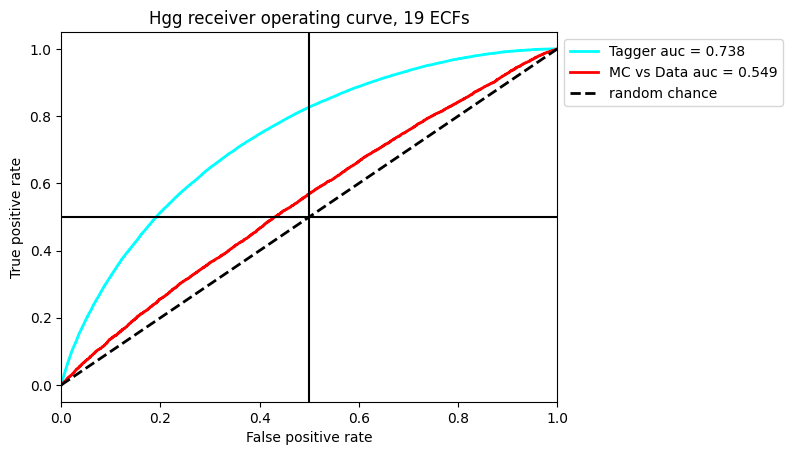

In [49]:
plt.plot(hgg_fpr, hgg_tpr, lw=2, color="cyan", label="Tagger auc = %.3f" % (hgg_auc))
plt.plot(md_fpr, md_tpr, lw=2, color="red", label="MC vs Data auc = %.3f" % (md_auc))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg receiver operating curve, {ecfs} ECFs")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f'combined_rocs/{ecfs}.png', bbox_inches='tight')
plt.show()

In [50]:
diffs = {}
for i in list(md_rocs.keys()):
    diffs[i] = hgg_rocs[i]['auc'] - md_rocs[i]['auc']

In [54]:
sorted(diffs.items(), key=lambda item: item[1], reverse=True)

[('28', 0.18952266554392383),
 ('19', 0.18928821065457246),
 ('34', 0.1875767683920221),
 ('50', 0.18382323236397746),
 ('75', 0.17863771162363085),
 ('100', 0.17420609763266404),
 ('85', 0.1738054646705599),
 ('135', 0.1703469644551685),
 ('229', 0.1563274286089621),
 ('256', 0.15309172147305894),
 ('1291', 0.14348568698645314)]

In [55]:
md_aucs = {}
for i in md_rocs:
    md_aucs[i] = md_rocs[i]['auc']

hgg_aucs = {}
for i in  hgg_rocs:
    hgg_aucs[i] = hgg_rocs[i]['auc']

In [63]:
common_keys = md_aucs.keys() & hgg_aucs.keys()
df = pd.DataFrame({
    'key': list(common_keys),
    'md_aucs': [md_aucs[k] for k in common_keys],
    'hgg_aucs': [hgg_aucs[k] for k in common_keys],
})

# Rank by high md values and low tg values (descending md, ascending tg)
df['rank'] = df['md_aucs'].rank(ascending=True) + df['hgg_aucs'].rank(ascending=False)

# Sort by combined ranking
df_sorted = df.sort_values('rank').reset_index(drop=True)

In [64]:
from sklearn.preprocessing import minmax_scale

df['md_scaled'] = minmax_scale(df['md_aucs'])
df['hgg_scaled'] = minmax_scale(df['hgg_aucs'])

df['combined_score'] = df['hgg_scaled'] - df['md_scaled']

df_sorted = df.sort_values('combined_score', ascending=False).reset_index(drop=True)

print(df_sorted[['key', 'md_aucs', 'hgg_aucs', 'combined_score']])

     key   md_aucs  hgg_aucs  combined_score
0     75  0.584554  0.763191        0.346710
1    100  0.591344  0.765550        0.334981
2     50  0.574321  0.758144        0.315491
3    135  0.595566  0.765912        0.291561
4     85  0.589440  0.763246        0.284483
5     34  0.565273  0.752850        0.260685
6     28  0.560224  0.749747        0.225228
7    229  0.610887  0.767215        0.133508
8    256  0.614650  0.767742        0.101485
9     19  0.549148  0.738436        0.000000
10  1291  0.625495  0.768981        0.000000
